In [95]:
import pandas as pd

col_names = ['wikiID','freeID','name','release_date','revenue','runtime','languages','countries','genres']
movies = pd.read_csv("movie.metadata.tsv",sep='\t',names=col_names)
movies.head()

,wikiID,freeID,name,release_date,revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [96]:
from dateutil.parser import parse
parse(movies['release_date'].iloc[2])

datetime.datetime(1988, 11, 3, 0, 0)

In [97]:
release_date = pd.to_datetime(movies['release_date'],errors='coerce')
mask = release_date.isna()
second_format = pd.to_datetime(movies['release_date'][mask],format='%Y',errors='coerce')
release_date[mask] = second_format
movies['release_date'] = release_date


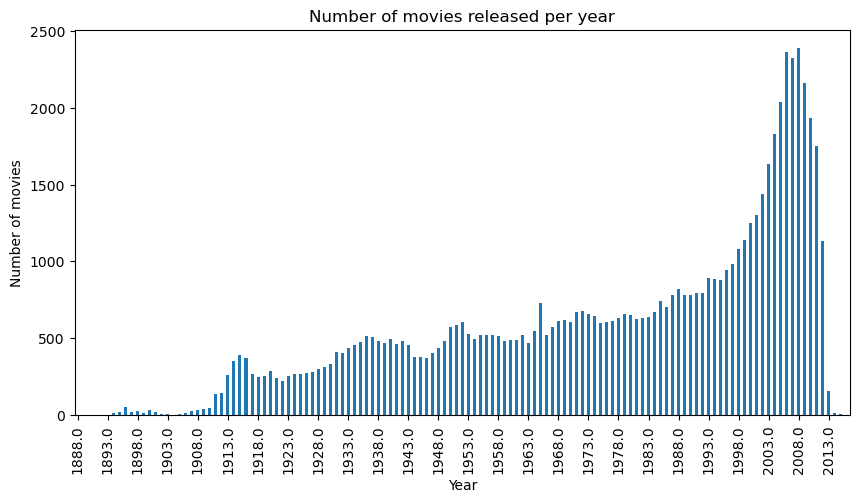

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
yearly_movies = movies.groupby(movies['release_date'].dt.year)['release_date'].count()
yearly_movies.plot(kind='bar',figsize=(10,5))
# plot 1 year every 10 years as x ticks
plt.xticks(np.arange(0, len(yearly_movies), 5))
plt.xlabel('Year')
plt.ylabel('Number of movies')
plt.title('Number of movies released per year')
plt.show()

In [89]:
yearly_movies = yearly_movies.reset_index(name='count').sort_values(['count'])

In [93]:
count_before2001 = yearly_movies[yearly_movies['release_date']<2001]['count'].sum()
count_after2001 = yearly_movies[yearly_movies['release_date']>=2001]['count'].sum()
print(f'Movies before the year 2001 are {count_before2001}')
print(f'Movies after the year 2001 are {count_after2001}')

Movies before the year 2001 are 49056
Movies after the year 2001 are 22488
